## Import Data

In [3]:
import pandas as pd

# Import the aranet4 data
aranet4 = pd.read_csv('../datasets/aranet4.csv')

# Create a dictionary for renaming the columns
rename_dict = {
    'Carbon dioxide(ppm)': 'CO2',
    'Temperature(°F)': 'Temperature',
    'Relative humidity(%)': 'Humidity',
    'Atmospheric pressure(hPa)': 'Pressure'
}

# Rename the columns
aranet4.rename(columns=rename_dict, inplace=True)
# Convert 'Date' and 'Datetime' columns to datetime objects
aranet4['Date'] = pd.to_datetime(aranet4['Date'])
aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])

# Extract features from 'Date' and 'Datetime'
aranet4['Year'] = aranet4['Date'].dt.year
aranet4['Month'] = aranet4['Date'].dt.month
aranet4['Day'] = aranet4['Date'].dt.day
aranet4['Hour'] = aranet4['Datetime'].dt.hour
aranet4['Minute'] = aranet4['Datetime'].dt.minute
aranet4['Second'] = aranet4['Datetime'].dt.second

# Calculate the 5-minute moving average of 'Humidity'
aranet4['Humidity_MA_5'] = aranet4['Humidity'].rolling(window=5, min_periods=1).mean()

# Replace missing 'Humidity' values with the moving average
aranet4['Humidity'].fillna(aranet4['Humidity_MA_5'], inplace=True)

# Replace any remaining NaN values with the overall mean
aranet4['Humidity'].fillna(aranet4['Humidity'].mean(), inplace=True)

# Drop the moving average column
aranet4.drop('Humidity_MA_5', axis=1, inplace=True)

def report_nan(df):
    return df.isnull().sum()

# Use the function on your DataFrame
print(report_nan(aranet4))
aranet4.info()

CO2               0
Temperature       0
Humidity          0
Pressure       2522
Date              0
Time              0
Datetime          0
Year              0
Month             0
Day               0
Hour              0
Minute            0
Second            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97857 entries, 0 to 97856
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CO2          97857 non-null  int64         
 1   Temperature  97857 non-null  float64       
 2   Humidity     97857 non-null  float64       
 3   Pressure     95335 non-null  float64       
 4   Date         97857 non-null  datetime64[ns]
 5   Time         97857 non-null  object        
 6   Datetime     97857 non-null  datetime64[ns]
 7   Year         97857 non-null  int64         
 8   Month        97857 non-null  int64         
 9   Day          97857 non-null  int64         
 10  Hour         97857 non-nu

Given that scikit-learn models work best with numerical data, it's a good idea to create a new DataFrame that only includes the numerical columns derived from the datetime data, along with the other numerical columns in your dataset.

As for the 'Year' and 'Second' columns, if they are constant for all records, they will not provide any useful information for a predictive model. A feature that is constant for all instances cannot have any predictive power, as it does not vary with the target variable. Therefore, you can safely drop these columns.

Here's how you can create a new DataFrame with only the relevant columns:



In [4]:
# Assuming 'aranet4' is your original DataFrame
numeric_columns = ['CO2', 'Temperature', 'Humidity', 'Pressure', 'Month', 'Day', 'Hour', 'Minute']
aranet4_numeric = aranet4[numeric_columns].copy()

print(aranet4_numeric.head())

    CO2  Temperature  Humidity  Pressure  Month  Day  Hour  Minute
0  1014         77.8      47.0    1007.3      1   12    16       8
1   884         78.5      46.0    1007.3      1   12    16       9
2   914         79.7      43.0    1007.4      1   12    16      10
3   906         79.7      42.0    1007.2      1   12    16      11
4   896         79.3      41.0    1007.3      1   12    16      12




This code creates a new DataFrame 'aranet4_numeric' that only includes the columns listed in 'numeric_columns', and then prints the first few rows of this new DataFrame. Adjust the list of columns as needed for your specific use case.

In [5]:
def report_nan(df):
    return df.isnull().sum()

# Use the function on your DataFrame
print(report_nan(aranet4_numeric))

CO2               0
Temperature       0
Humidity          0
Pressure       2522
Month             0
Day               0
Hour              0
Minute            0
dtype: int64


## Replacing Pressure `NaN`s

### Linear Interpolation
One approach could be to use interpolation to fill the missing values. Interpolation will fill the missing values based on the values at the start and end of the gap, creating a linear trend (or some other kind of trend, depending on the method you choose) during the gap.

Here's how you can use linear interpolation to fill the missing `Pressure` values:

In [31]:
# Use linear interpolation to fill missing 'Pressure' values
aranet4_numeric['Pressure'].interpolate(method='linear', inplace=True)

# Check the number of NaN values again
print(report_nan(aranet4_numeric))

CO2            0
Temperature    0
Humidity       0
Pressure       0
Month          0
Day            0
Hour           0
Minute         0
dtype: int64


This code uses the interpolate method with the 'linear' method, which will create a straight line between the start and end of the gap and use this line to fill the missing values. It then checks the number of NaN values again.

Please note that this is a simple form of imputation and might not always be the best approach, especially if the data has complex temporal patterns. More advanced methods like time series forecasting could be used to fill the gap, but these methods are also more complex to implement.

### Linear Regression

Yes, you can use a linear regression model (or any other suitable regression model) to predict the missing 'Pressure' values based on the other predictors in your dataset. This is a form of multivariate imputation that can be more accurate than univariate methods (like mean, median, or most common value imputation) when the predictors are informative.

Here's a basic example of how you can do this using scikit-learn's `LinearRegression`:



In [91]:
from sklearn.linear_model import LinearRegression

# Split the data into sets with and without missing 'Pressure' values
train_data = aranet4_numeric[aranet4_numeric['Pressure'].notna()]
test_data = aranet4_numeric[aranet4_numeric['Pressure'].isna()]

# Define the predictors and target
predictors = ['CO2', 'Temperature', 'Humidity', 'Month', 'Day', 'Hour', 'Minute']
target = 'Pressure'

# Train the model
model = LinearRegression()
model.fit(train_data[predictors], train_data[target])

# Predict the missing 'Pressure' values and assign them directly in the DataFrame
test_data.loc[:, 'Pressure'] = model.predict(test_data[predictors])

# Combine the data back together
aranet4_numeric = pd.concat([train_data, test_data])

# Sort the DataFrame by the index
aranet4_numeric.sort_index(inplace=True)

# Check the number of NaN values again
print(report_nan(aranet4_numeric))

CO2            0
Temperature    0
Humidity       0
Pressure       0
Month          0
Day            0
Hour           0
Minute         0
dtype: int64


C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_62792\2517051207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'Pressure'] = model.predict(test_data[predictors])




This code first splits the data into two sets: one with missing 'Pressure' values (which will be used for prediction) and one without (which will be used for training the model). It then trains a `LinearRegression` model on the training data and uses this model to predict the missing 'Pressure' values in the test data. Finally, it combines the data back together and checks the number of NaN values again.

Please note that this is a simple example and might not be the best approach for your specific problem. For example, it assumes that the missing 'Pressure' values are missing completely at random, which might not be the case. More advanced methods, such as multiple imputation, might be more appropriate in some cases.

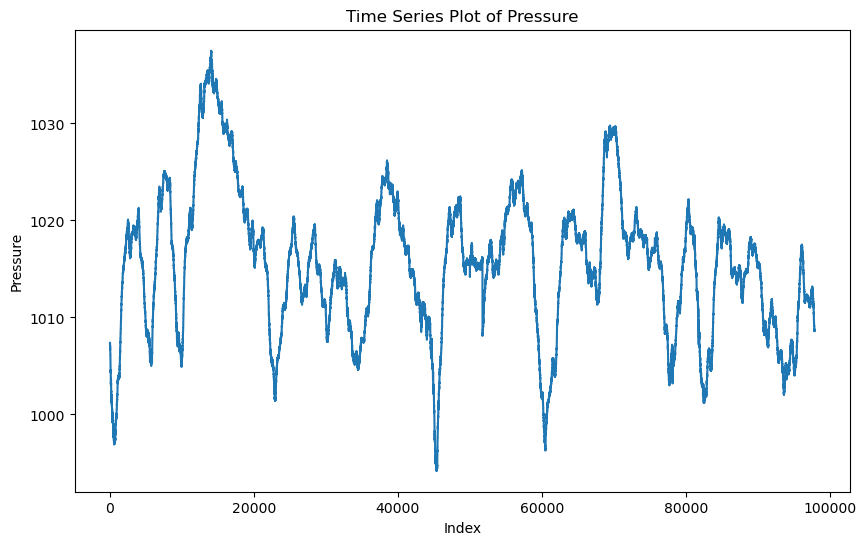

In [53]:
import matplotlib.pyplot as plt

# Create a time series plot of 'Pressure'
plt.figure(figsize=(10, 6))
plt.plot(aranet4_numeric.index, aranet4_numeric['Pressure'])
plt.title('Time Series Plot of Pressure')
plt.xlabel('Index')
plt.ylabel('Pressure')
plt.show()

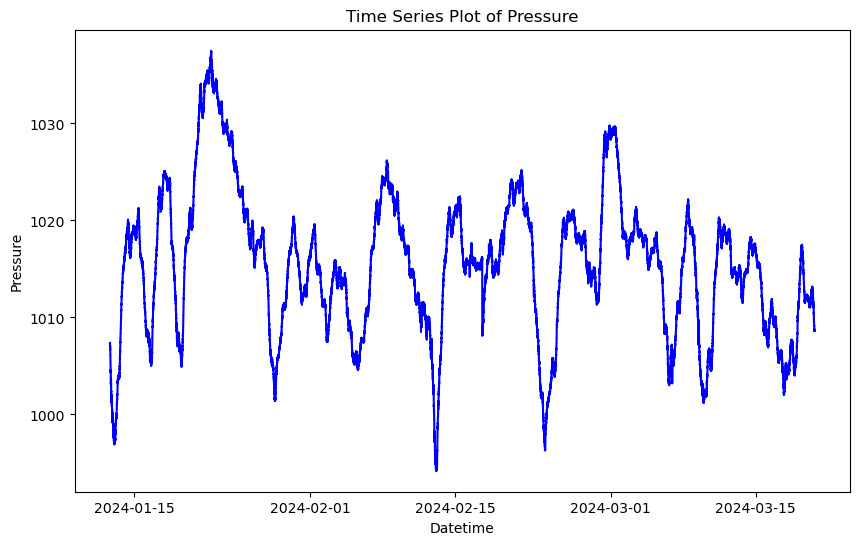

In [56]:
# Create a time series plot of 'Pressure', with different colors for imputed values
plt.figure(figsize=(10, 6))

# Plot non-imputed values
plt.plot(plot_df.loc[~plot_df['Imputed'], 'Datetime'], plot_df.loc[~plot_df['Imputed'], 'Pressure'], color='blue')

# Plot imputed values
plt.plot(plot_df.loc[plot_df['Imputed'], 'Datetime'], plot_df.loc[plot_df['Imputed'], 'Pressure'], color='red')

plt.title('Time Series Plot of Pressure')
plt.xlabel('Datetime')
plt.ylabel('Pressure')
plt.show()

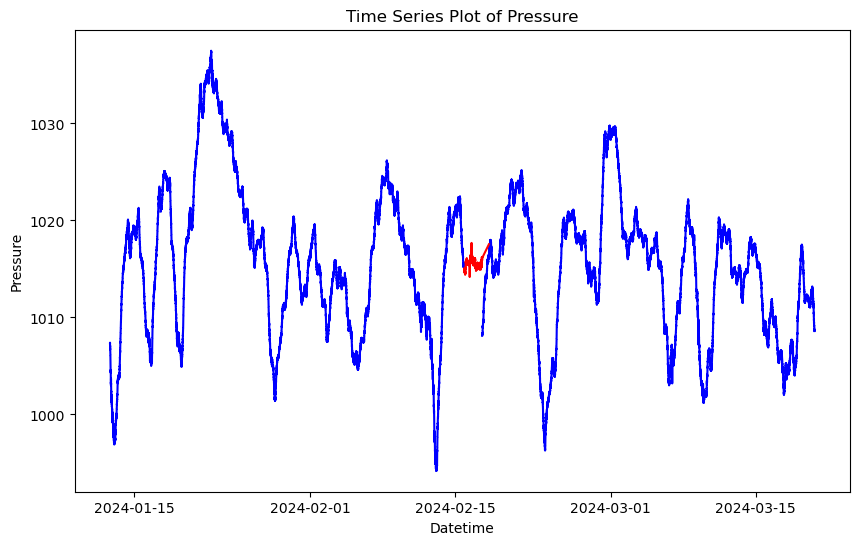

In [64]:
# Copy aranet4_numeric to a new DataFrame for plotting
plot_df = aranet4_numeric.copy()

# Add the 'Datetime' and 'Pressure' columns from aranet4
plot_df['Datetime'] = aranet4['Datetime']
plot_df['Pressure_Original'] = aranet4['Pressure']

# Create a new column 'Imputed' that is True for indices where 'Pressure_Original' is NaN
plot_df['Imputed'] = plot_df['Pressure_Original'].isna()

# Create a time series plot of 'Pressure', with different colors for imputed values
plt.figure(figsize=(10, 6))

# Plot original 'Pressure' values
plt.plot(plot_df['Datetime'], plot_df['Pressure_Original'], color='blue')

# Get the Datetime values for the imputed data
imputed_datetime = plot_df.loc[plot_df['Imputed'], 'Datetime']

# Get the Pressure values for the imputed data
imputed_pressure = plot_df.loc[plot_df['Imputed'], 'Pressure']

# Plot imputed 'Pressure' values
plt.plot(imputed_datetime, imputed_pressure, color='red')
plt.title('Time Series Plot of Pressure')
plt.xlabel('Datetime')
plt.ylabel('Pressure')
plt.show()

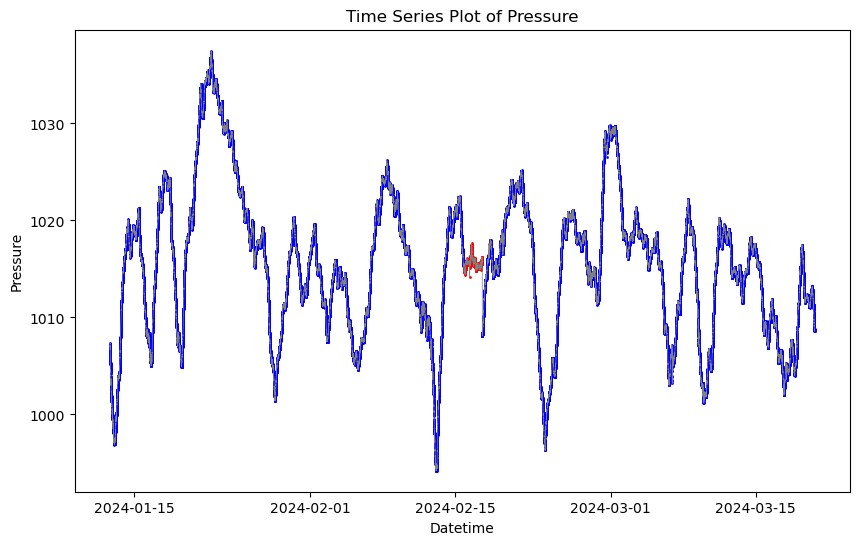

In [67]:
# Create a time series plot of 'Pressure', with different colors for imputed values
plt.figure(figsize=(10, 6))

# Plot all 'Pressure' values with connections
plt.plot(plot_df['Datetime'], plot_df['Pressure'], color='grey', linewidth=0.5)  # Adjust the thickness here

# Scatter plot for original 'Pressure' values
plt.scatter(plot_df.loc[~plot_df['Imputed'], 'Datetime'], plot_df.loc[~plot_df['Imputed'], 'Pressure'], color='blue', s=1)

# Scatter plot for imputed 'Pressure' values
plt.scatter(plot_df.loc[plot_df['Imputed'], 'Datetime'], plot_df.loc[plot_df['Imputed'], 'Pressure'], color='red', s=1)

plt.title('Time Series Plot of Pressure')
plt.xlabel('Datetime')
plt.ylabel('Pressure')
plt.show()

## Imputed Aranet Dataset

In [68]:
aranet4_clean = aranet4_numeric.copy()
aranet4_clean.head()

,CO2,Temperature,Humidity,Pressure,Month,Day,Hour,Minute
0,1014,77.8,47.0,1007.3,1,12,16,8
1,884,78.5,46.0,1007.3,1,12,16,9
2,914,79.7,43.0,1007.4,1,12,16,10
3,906,79.7,42.0,1007.2,1,12,16,11
4,896,79.3,41.0,1007.3,1,12,16,12


In [69]:
aranet4_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97857 entries, 0 to 97856
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CO2          97857 non-null  int64  
 1   Temperature  97857 non-null  float64
 2   Humidity     97857 non-null  float64
 3   Pressure     97857 non-null  float64
 4   Month        97857 non-null  int64  
 5   Day          97857 non-null  int64  
 6   Hour         97857 non-null  int64  
 7   Minute       97857 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 6.7 MB


In [109]:
from sklearn.linear_model import LinearRegression
# Copy the original DataFrame
aranet4_copy = aranet4.copy()

# Calculate the 5-minute moving average of 'Humidity'
aranet4_copy['Humidity_MA_5'] = aranet4_copy['Humidity'].rolling(window=5, min_periods=1).mean()

# Replace missing 'Humidity' values with the moving average
aranet4_copy['Humidity'].fillna(aranet4_copy['Humidity_MA_5'], inplace=True)

# Replace any remaining NaN values with the overall mean
aranet4_copy['Humidity'].fillna(aranet4_copy['Humidity'].mean(), inplace=True)

# Drop the moving average column
aranet4_copy.drop('Humidity_MA_5', axis=1, inplace=True)

# Define the predictors and target
predictors = ['CO2', 'Temperature', 'Humidity', 'Month', 'Day', 'Hour', 'Minute']
target = 'Pressure'

# Split the data into sets with and without missing 'Pressure' values
known_data = aranet4_copy[aranet4_copy['Pressure'].notna()]
unknown_data = aranet4_copy[aranet4_copy['Pressure'].isna()]

# Print the number of NaN values in the known and unknown data
print("NaN values in known data:", known_data.isna().sum().sum())
print("NaN values in unknown data:", unknown_data.isna().sum().sum())

# Further split the known data into training and testing sets
# The last 2 days of data are used for testing
train_data = known_data.loc[known_data['Datetime'] < known_data['Datetime'].max() - pd.DateOffset(days=2)]
test_data = known_data.loc[known_data['Datetime'] >= known_data['Datetime'].max() - pd.DateOffset(days=2)]

# Drop non-numeric columns from the training, testing, and unknown data
train_data = train_data[predictors + [target]]
test_data = test_data[predictors + [target]]
unknown_data = unknown_data[predictors + [target]]

# Print the number of NaN values in the training, testing, and unknown data
print("NaN values in training data:", train_data.isna().sum().sum())
print("NaN values in testing data:", test_data.isna().sum().sum())
print("NaN values in unknown data:", unknown_data.isna().sum().sum())

# Train the model on the training data
model = LinearRegression()
model.fit(train_data[predictors], train_data[target])

# Predict the 'Pressure' values in the testing data
test_data.loc[:, 'Pressure'] = model.predict(test_data[predictors])

# Predict the missing 'Pressure' values in the unknown data
unknown_data_predictions = model.predict(unknown_data.drop(columns=[target]))
unknown_data.loc[:, 'Pressure'] = unknown_data_predictions
# Combine the data back together
aranet4_numeric = pd.concat([train_data, test_data, unknown_data])

# Sort the DataFrame by the index
aranet4_numeric.sort_index(inplace=True)

# Check the number of NaN values again
print("NaN values in the final data:", aranet4_numeric.isna().sum().sum())

# Store the actual 'Pressure' values from the testing data
actual_values = test_data[target].copy()

# Predict the 'Pressure' values in the testing data
test_data.loc[:, 'Pressure'] = model.predict(test_data[predictors])

# Calculate the mean squared error of the predictions
mse = mean_squared_error(actual_values, test_data[target])
print("Mean squared error:", mse)

# Calculate the R^2 score of the predictions
r2 = r2_score(actual_values, test_data[target])
print("R^2 score:", r2)

NaN values in known data: 0
NaN values in unknown data: 2522
NaN values in training data: 0
NaN values in testing data: 0
NaN values in unknown data: 2522
NaN values in the final data: 0
Mean squared error: 0.0
R^2 score: 1.0


In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Copy the original DataFrame
aranet4_copy = aranet4.copy()

# Calculate the 5-minute moving average of 'Humidity'
aranet4_copy['Humidity_MA_5'] = aranet4_copy['Humidity'].rolling(window=5, min_periods=1).mean()

# Replace missing 'Humidity' values with the moving average
aranet4_copy['Humidity'].fillna(aranet4_copy['Humidity_MA_5'], inplace=True)

# Replace any remaining NaN values with the overall mean
aranet4_copy['Humidity'].fillna(aranet4_copy['Humidity'].mean(), inplace=True)

# Drop the moving average column
aranet4_copy.drop('Humidity_MA_5', axis=1, inplace=True)

# Define the predictors and target
predictors = ['CO2', 'Temperature', 'Humidity', 'Month', 'Day', 'Hour', 'Minute']
target = 'Pressure'

# Split the data into sets with and without missing 'Pressure' values
known_data = aranet4_copy[aranet4_copy['Pressure'].notna()]
unknown_data = aranet4_copy[aranet4_copy['Pressure'].isna()]

# Further split the known data into training and testing sets
# The last 2 days of data are used for testing
train_data = known_data.loc[known_data['Datetime'] < known_data['Datetime'].max() - pd.DateOffset(days=2)]
test_data = known_data.loc[known_data['Datetime'] >= known_data['Datetime'].max() - pd.DateOffset(days=2)]

# Drop non-numeric columns from the training, testing, and unknown data
train_data = train_data[predictors + [target]]
test_data = test_data[predictors + [target]]
unknown_data = unknown_data[predictors + [target]]

# Train the model on the training data
model = LinearRegression()
model.fit(train_data[predictors], train_data[target])

# Store the actual 'Pressure' values from the testing data
actual_values = test_data[target].copy()

# Predict the 'Pressure' values in the testing data
test_predictions = model.predict(test_data[predictors])

# Replace the 'Pressure' values in the testing data with the predictions
test_data.loc[:, 'Pressure'] = test_predictions

# Predict the missing 'Pressure' values in the unknown data
unknown_data_predictions = model.predict(unknown_data.drop(columns=[target]))
unknown_data.loc[:, 'Pressure'] = unknown_data_predictions

# Combine the data back together
aranet4_numeric = pd.concat([train_data, test_data, unknown_data])

# Sort the DataFrame by the index
aranet4_numeric.sort_index(inplace=True)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(actual_values, test_predictions)
print("Mean squared error:", mse)

# Calculate the R^2 score of the predictions
r2 = r2_score(actual_values, test_predictions)
print("R^2 score:", r2)

Mean squared error: 35.98645855422343
R^2 score: -2.1088633560117573


### Random Forest


In [119]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Copy the original DataFrame
aranet4_copy = aranet4.copy()

# Calculate the 5-minute moving average of 'Humidity'
aranet4_copy['Humidity_MA_5'] = aranet4_copy['Humidity'].rolling(window=5, min_periods=1).mean()

# Replace missing 'Humidity' values with the moving average
aranet4_copy['Humidity'].fillna(aranet4_copy['Humidity_MA_5'], inplace=True)

# Replace any remaining NaN values with the overall mean
aranet4_copy['Humidity'].fillna(aranet4_copy['Humidity'].mean(), inplace=True)

# Drop the moving average column
aranet4_copy.drop('Humidity_MA_5', axis=1, inplace=True)

# Define the predictors and target
predictors = ['CO2', 'Temperature', 'Humidity', 'Month', 'Day', 'Hour', 'Minute']
target = 'Pressure'

# Split the data into sets with and without missing 'Pressure' values
known_data = aranet4_copy[aranet4_copy['Pressure'].notna()]
unknown_data = aranet4_copy[aranet4_copy['Pressure'].isna()]

# Further split the known data into training and testing sets
# The last 2 days of data are used for testing
train_data = known_data.loc[known_data['Datetime'] < known_data['Datetime'].max() - pd.DateOffset(days=2)]
test_data = known_data.loc[known_data['Datetime'] >= known_data['Datetime'].max() - pd.DateOffset(days=2)]

# Drop non-numeric columns from the training, testing, and unknown data
train_data = train_data[predictors + [target]]
test_data = test_data[predictors + [target]]
unknown_data = unknown_data[predictors + [target]]

# Train the Gradient Boosting model on the training data
model = GradientBoostingRegressor()
model.fit(train_data[predictors], train_data[target])


GradientBoostingRegressor()

#### Measures

In [120]:

# Store the actual 'Pressure' values from the testing data
actual_values = test_data[target].copy()

# Predict the 'Pressure' values in the testing data
test_predictions = model.predict(test_data[predictors])

# Calculate the mean squared error of the predictions
mse = mean_squared_error(actual_values, test_predictions)
print("Mean squared error:", mse)

# Calculate the R^2 score of the predictions
r2 = r2_score(actual_values, test_predictions)
print("R^2 score:", r2)

Mean squared error: 19.503797623693334
R^2 score: -0.6849293920936048


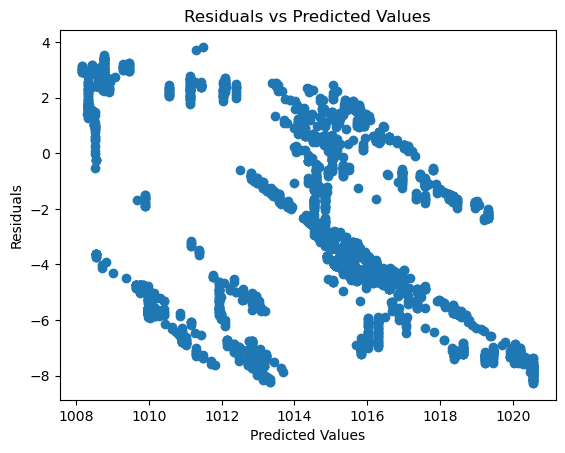

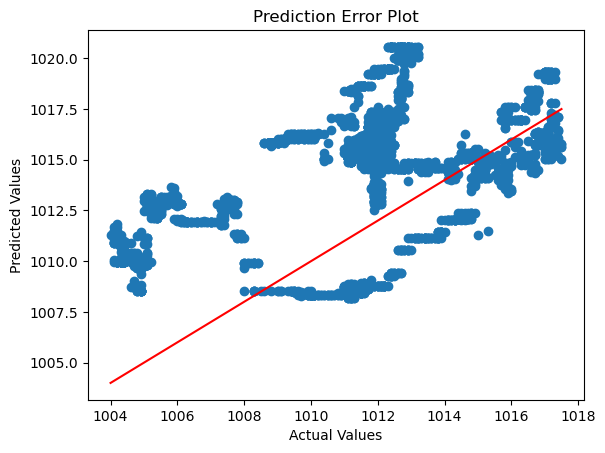

In [123]:
import matplotlib.pyplot as plt

residuals = actual_values - test_predictions
plt.scatter(test_predictions, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

plt.scatter(actual_values, test_predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Error Plot')
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], color='red')
plt.show()


### Support Vector Machine Model

In [124]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Train the SVM model on the training data
model = SVR()
model.fit(train_data[predictors], train_data[target])

# Store the actual 'Pressure' values from the testing data
actual_values = test_data[target].copy()

# Predict the 'Pressure' values in the testing data
test_predictions = model.predict(test_data[predictors])

# Calculate the mean squared error of the predictions
mse = mean_squared_error(actual_values, test_predictions)
print("Mean squared error:", mse)

# Calculate the R^2 score of the predictions
r2 = r2_score(actual_values, test_predictions)
print("R^2 score:", r2)

# Predict the missing 'Pressure' values in the unknown data
unknown_data_predictions = model.predict(unknown_data.drop(columns=[target]))
unknown_data.loc[:, 'Pressure'] = unknown_data_predictions

# Combine the data back together
aranet4_numeric = pd.concat([train_data, test_data, unknown_data])

# Sort the DataFrame by the index
aranet4_numeric.sort_index(inplace=True)

In [3]:
# Copy the original DataFrame
aranet4_copy = aranet4.copy()

# Calculate the 5-minute moving average of 'Humidity'
aranet4_copy['Humidity_MA_5'] = aranet4_copy['Humidity'].rolling(window=5, min_periods=1).mean()

# Replace missing 'Humidity' values with the moving average
aranet4_copy['Humidity'].fillna(aranet4_copy['Humidity_MA_5'], inplace=True)

# Replace any remaining NaN values with the overall mean
aranet4_copy['Humidity'].fillna(aranet4_copy['Humidity'].mean(), inplace=True)

# Drop the moving average column
aranet4_copy.drop('Humidity_MA_5', axis=1, inplace=True)

# Calculate the 2880-minute (2-day) lag for 'Pressure'
aranet4_copy['Pressure_Lag_2880'] = aranet4_copy['Pressure'].shift(2880)

# Now include 'Pressure_Lag_2880' in your predictors
predictors = ['CO2', 'Temperature', 'Humidity', 'Month', 'Day', 'Hour', 'Minute', 'Pressure_Lag_2880']

# You must drop the first 2880 rows since they will have NaN values for the lag variable
aranet4_copy = aranet4_copy.iloc[2880:]

target = 'Pressure'

# Split the data into sets with and without missing 'Pressure' values
known_data = aranet4_copy[aranet4_copy['Pressure'].notna()]
unknown_data = aranet4_copy[aranet4_copy['Pressure'].isna()]

# Further split the known data into training and testing sets
# The last 2 days of data are used for testing
train_data = known_data.loc[known_data['Datetime'] < known_data['Datetime'].max() - pd.DateOffset(days=2)]
test_data = known_data.loc[known_data['Datetime'] >= known_data['Datetime'].max() - pd.DateOffset(days=2)]

# Drop non-numeric columns from the training, testing, and unknown data
train_data = train_data[predictors + [target]]
test_data = test_data[predictors + [target]]
unknown_data = unknown_data[predictors + [target]]
# Store the actual 'Pressure' values from the testing data
actual_values = test_data[target].copy()
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define the models to test
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor())
    # ('SVM', SVR())
]

# Iterate over the models
for name, model in models:
    # Train the model
    model.fit(train_data[predictors], train_data[target])

    # Make predictions
    test_predictions = model.predict(test_data[predictors])

    # Calculate the mean squared error
    mse = mean_squared_error(actual_values, test_predictions)
    print(f"{name} MSE: {mse}")

    # Calculate the R^2 score
    r2 = r2_score(actual_values, test_predictions)
    print(f"{name} R^2: {r2}")

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Copy the original DataFrame
aranet4_copy = aranet4.copy()

# Calculate the 2880-minute (2-day) lag for 'Pressure'
aranet4_copy['Pressure_Lag_2880'] = aranet4_copy['Pressure'].shift(14400)

# Define the predictors and target
predictors = ['Humidity', 'Month', 'Day', 'Hour', 'Minute', 'Pressure_Lag_2880']
target = 'Pressure'

# Drop rows with NaN values in the predictors or the target
aranet4_copy.dropna(subset=predictors + [target], inplace=True)

# Split the data into sets with and without missing 'Pressure' values
known_data = aranet4_copy[aranet4_copy['Pressure'].notna()]
unknown_data = aranet4_copy[aranet4_copy['Pressure'].isna()]

# Further split the known data into training and testing sets
# The last 2 days of data are used for testing
train_data = known_data.loc[known_data['Datetime'] < known_data['Datetime'].max() - pd.DateOffset(days=2)]
test_data = known_data.loc[known_data['Datetime'] >= known_data['Datetime'].max() - pd.DateOffset(days=2)]

# Select the predictors and the target
train_data = train_data[predictors + [target]]
test_data = test_data[predictors + [target]]
unknown_data = unknown_data[predictors]

# Store the actual 'Pressure' values from the testing data
actual_values = test_data[target].copy()

# Define the models to test
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor())
]

# Iterate over the models
for name, model in models:
    # Train the model
    model.fit(train_data[predictors], train_data[target])

    # Make predictions
    test_predictions = model.predict(test_data[predictors])

    # Calculate the mean squared error
    mse = mean_squared_error(actual_values, test_predictions)
    print(f"{name} MSE: {mse}")

    # Calculate the R^2 score
    r2 = r2_score(actual_values, test_predictions)
    print(f"{name} R^2: {r2}")


Linear Regression MSE: 18.68226879024767
Linear Regression R^2: -0.6139576713737684
Random Forest MSE: 37.54302737764737
Random Forest R^2: -2.2433350426035763
Gradient Boosting MSE: 17.283869012178766
Gradient Boosting R^2: -0.49315017872920097


### SARIMA Time-series Model